# Fibril Generator and CyRSoXS Simulation

In [7]:
from scipy.interpolate import interp1d
from scipy.ndimage import rotate
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import trimesh
import os
import pyembree
import random
import pickle
import sys
import pathlib
import subprocess
import h5py

from PyHyperScattering.load import cyrsoxsLoader
from PyHyperScattering.integrate import WPIntegrator

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import LogNorm

import numpy as np
import io
from PIL import Image
import PIL

import open3d as o3d

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define path to NRSS and PyHyperScattering

In [8]:
sys.path.append('C:/Users/Phong/NRSS/')
sys.path.append('C:/Users/Phong/DopantModeling')
from NRSS.writer import write_materials, write_hdf5, write_config, write_slurm
from NRSS.checkH5 import checkH5
from Morphology import Morphology 
from Fibril import Fibril
from PostProcessor import PostProcessor

## Define and generate fibril morphology

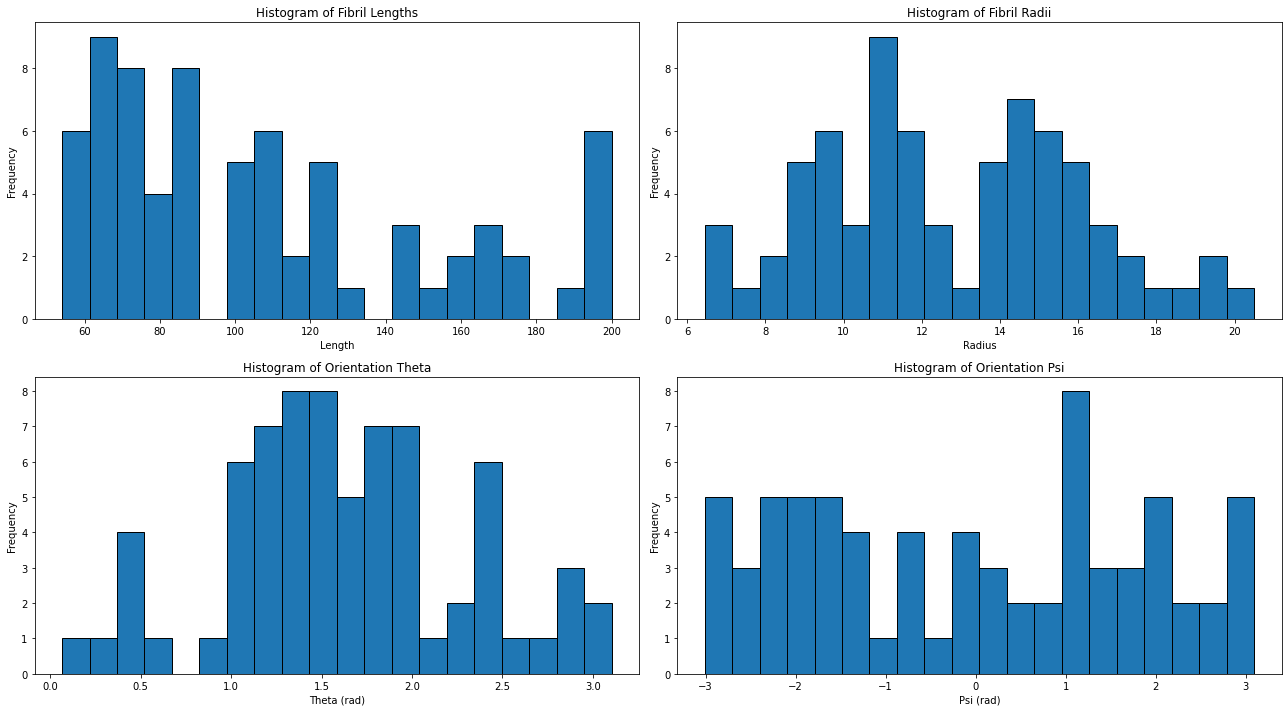

Filling model:  29%|███████████████████                                               | 72/250 [06:31<16:08,  5.44s/it]


KeyboardInterrupt: 

In [9]:
# Declare model box size in nm (x,y,z)
# x_dim_nm  = 2500
# y_dim_nm  = 2500
# z_dim_nm  = 20
x_dim_nm  = 256
y_dim_nm  = 256
z_dim_nm  = 256
pitch_nm = 2 # Dimension of voxel in nm

# Initialize morphology
morphology = Morphology(x_dim_nm, y_dim_nm, z_dim_nm, pitch_nm)
morphology.set_model_parameters(radius_nm_avg = 15,
                                radius_nm_std = 3,
                                max_num_fibrils = 250,
                                fibril_length_range_nm = [50, 200],
                                rand_orientation = 3, # sample psi and theta using gaussian random fields
                                theta_distribution_csv = r'C:\Users\Phong\DopantModeling\theta_distributions\avg_0p1_theta_distribution.csv',
#                                 k = 1/6,
#                                 std = 1/25)
                                k = 1/25,
                                std = 1/125)

morphology.fill_model(timeout = 360, plot_histogram=True)

(10000.0, 1000000000.0)

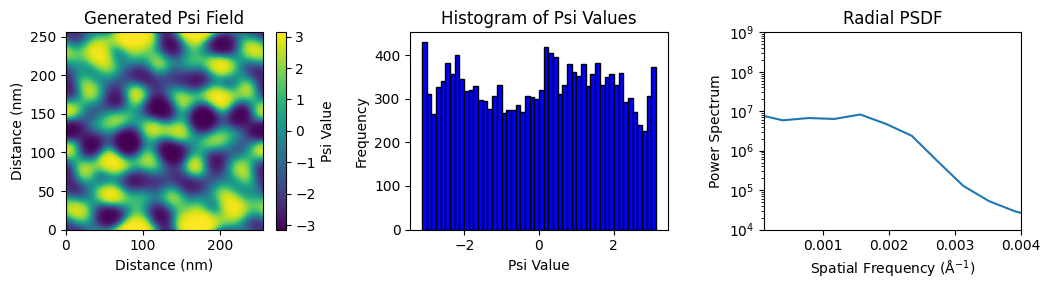

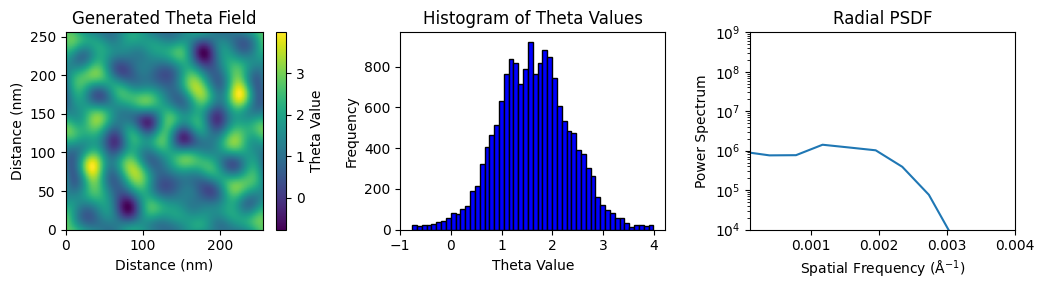

In [10]:
fig1, ax1 = morphology.plot_field('psi')
fig2, ax2 = morphology.plot_field('theta')
ax1[2].set_xlim([0.0001, 0.004])
ax1[2].set_ylim([1e4, 1e9])
ax2[2].set_xlim([0.0001, 0.004])
ax2[2].set_ylim([1e4, 1e9])

In [11]:
# May not show if the morphology is too large (too many fibrils)
scene = morphology.get_scene(show_bounding_box=True)
scene.show()

In [12]:
morphology.voxelize_model()

Voxelizing Fibrils: 100%|██████████████████████████████████████████████████████████████| 72/72 [01:07<00:00,  1.07it/s]


## Save voxelized morphology as reduced morphology

In [13]:
from ReducedMorphology import ReducedMorphology
rm = ReducedMorphology(morphology)

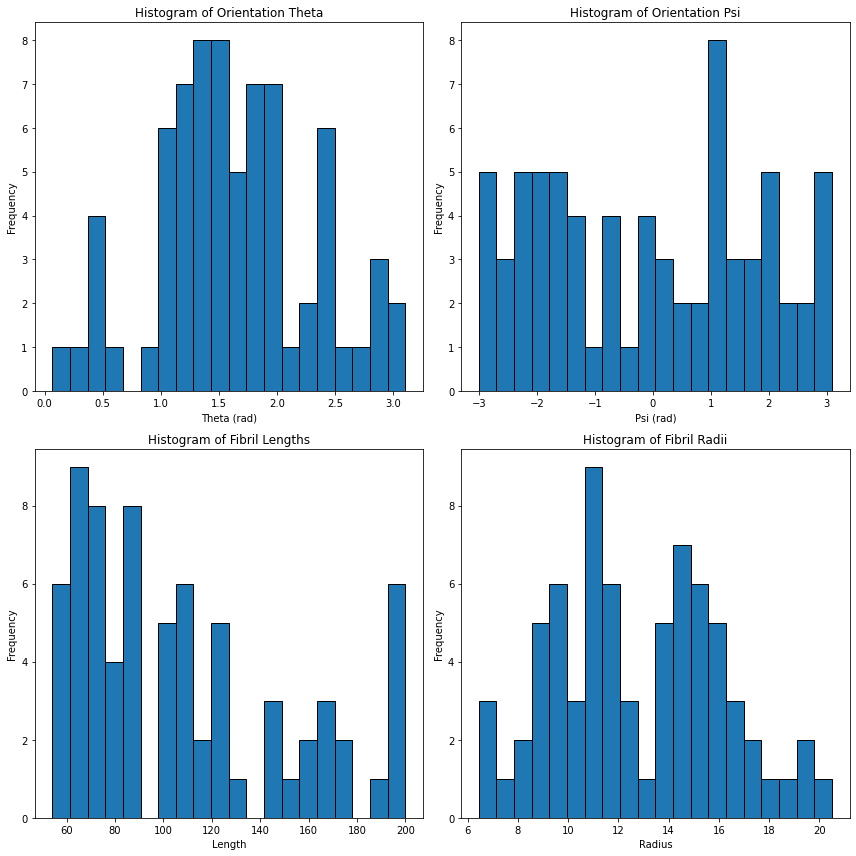

In [14]:
fig, ax = rm.plot_fibril_histogram()

In [15]:
rm.pickle()

## Load voxelized reduced morphology

In [16]:
from PostProcessor import PostProcessor

most_recent_file = None
most_recent_mtime = 0

# Iterate through all subdirectories and find the most recently modified .pickle file
for root, dirs, files in os.walk('.'):
    for filename in files:
        if filename.endswith('.pickle') and 'HDF5' not in os.listdir(root):
            full_path = os.path.abspath(os.path.join(root, filename))
            mtime = os.path.getmtime(full_path)
            if mtime > most_recent_mtime:
                most_recent_mtime = mtime
                most_recent_file = full_path

# Load the most recently modified .pickle file
rm = None
if most_recent_file:
    print(f"Loading the most recently modified file: {most_recent_file}")
    with open(most_recent_file, 'rb') as f:
        rm = pickle.load(f)
else:
    print("No pickle files found.")

Loading the most recently modified file: C:\Users\Phong\DopantModeling\Jupyter Notebooks\256x256x256nm_pitch2nm_rad15nm_std3nm_72fib_50-200nm.pickle


## Create material matricies

Iterating over fibrils: 100%|██████████████████████████████████████████████████████████| 72/72 [00:05<00:00, 13.33it/s]


Adding core-shell structure...
Handling amorphous material without surface roughness...
Setting amorphous orientation...


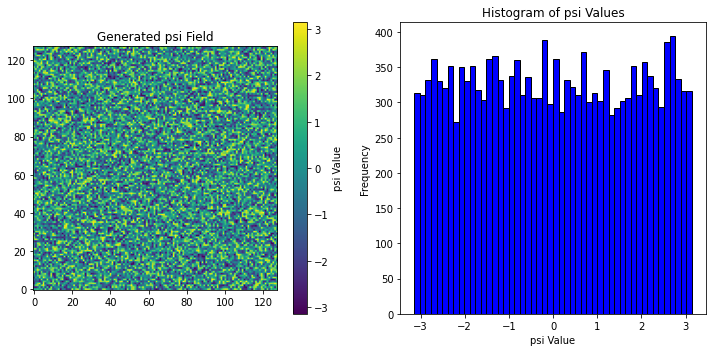

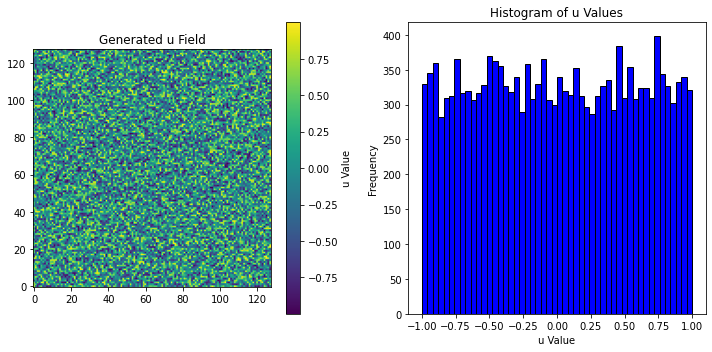

Adding preferential dopant...


Progress: 100%|██████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 27.18it/s]


Setting dopant orientation...
Material matrices generation completed.

Aggregate Mole Fraction = 0.27075286261614756
Amorphous Mole Fraction = 0.6794913796797744
Dopant Mole Fraction = 0.049755757704078134

Aggregate Volume Fraction = 0.26213537795821146
Amorphous Volume Fraction = 0.6578646220417885
Dopant Volume Fraction = 0.08


In [18]:
VACUUM_ID  = 0 # Vacuum
CRYSTAL_ID = 1 # Crystalline P3HT
AMORPH_ID  = 2 # Amorphous P3HT
DOPANT_ID  = 3 # Dopant (optional)

mol_weight = {
    CRYSTAL_ID: 166.2842, # Molecular weight of crystalline P3HT
    AMORPH_ID: 166.2842,  # Molecular weight of amorphous P3HT
    DOPANT_ID: 276.15     # Molecular weight of TFSI- = 280.14, Molecular weight of F4TCNQ = 276.15
}

density = {
    CRYSTAL_ID: 1.1, # Density of crystalline P3HT
    AMORPH_ID: 1.1,  # Density of amorphous P3HT
    DOPANT_ID: 1.1   # Density of dopant in P3HT
}

# PostProcessor Setup
post_processor = PostProcessor(
    num_materials=4, mol_weight=mol_weight, density=density,
    dope_case=1, dopant_method='preferential', dopant_orientation='perpendicular', 
    dopant_vol_frac=0.08, crystal_dope_frac = 1,
    core_shell_morphology=True, gaussian_std=3, fibril_shell_cutoff=0.2, 
    surface_roughness=False, height_feature=3, max_valley_nm=46, 
    amorph_matrix_Vfrac=0.9, amorphous_orientation=True)

mat_Vfrac, mat_S, mat_theta, mat_psi = post_processor.generate_material_matrices(rm)

crystalline_mol_fraction, amorphous_mol_fraction, dopant_mol_fraction = post_processor.analyze_mol_fractions(mat_Vfrac)
print("")
print(f"Aggregate Mole Fraction = {crystalline_mol_fraction}")
print(f"Amorphous Mole Fraction = {amorphous_mol_fraction}")
print(f"Dopant Mole Fraction = {dopant_mol_fraction}")

crystalline_vol_fraction, amorphous_vol_fraction, dopant_vol_fraction = post_processor.analyze_vol_fractions(mat_Vfrac)
print("")
print(f"Aggregate Volume Fraction = {crystalline_vol_fraction}")
print(f"Amorphous Volume Fraction = {amorphous_vol_fraction}")
print(f"Dopant Volume Fraction = {dopant_vol_fraction}")

In [20]:
phys_size = 2.0
write_hdf5([[mat_Vfrac[0], mat_S[0], mat_theta[0], mat_psi[0]], 
            [mat_Vfrac[1], mat_S[1], mat_theta[1], mat_psi[1]],
            [mat_Vfrac[2], mat_S[2], mat_theta[2], mat_psi[2]],
            [mat_Vfrac[3], mat_S[3], mat_theta[3], mat_psi[3]]],
            phys_size, 'Fibril.hdf5')

--> Marking Fibril.hdf5


'Fibril.hdf5'

In [21]:
checkH5('Fibril.hdf5', z_slice=55, plotstyle='light')

AssertionError: Not all voxels in morphology have Total Material equal to 1

# Visualize morphology:

In [ ]:
def array2voxel(voxel_array):
    """
    convert a to a fixed size array to voxel_grid_index array
    (voxel_size*voxel_size*voxel_size)->(N*3)
    
    :input voxel_array: array with shape(voxel_size*voxel_size*voxel_size),the grid_index in 
    :return grid_index_array: get from o3d.voxel_grid.get_voxels()
    """
    x,y,z=np.where(voxel_array>0)
    voxel_mask = np.where(voxel_array>0)
    # x,y,z = voxel_mask
    valid_voxels = voxel_array[voxel_mask]
    index_voxel=np.vstack((x,y,z))
    grid_index_array=index_voxel.T
    return grid_index_array, valid_voxels

# frame = o3d.geometry.TriangleMesh.create_coordinate_frame(1)
voxel_array = mat_Vfrac[1]
# voxel_array = np.where(mat_Vfrac[0]<1,1,0)
grid_index_array, valid_voxels = array2voxel(voxel_array)
pointcloud_array=grid_index_array*0.03125#0.03125 is voxel_size
pc=o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(pointcloud_array)

color_max_array = np.array([[100], [100], [100]])
colors = np.dot(color_max_array, [valid_voxels]).T
pc.colors = o3d.utility.Vector3dVector(colors / 255.0)
print("pc created")

o3d_voxel=o3d.geometry.VoxelGrid.create_from_point_cloud(pc, voxel_size=0.03125)
print("Voxel created")
o3d.visualization.draw_geometries([o3d_voxel])

In [ ]:
from pyvox.models import Vox
from pyvox.writer import VoxWriter
combmatFrac = mat_Vfrac[1]+mat_Vfrac[2]
voxmat = [[Vox.from_dense(np.ceil(combmatFrac[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'voxFile{a}x_{b}y.vox',voxmat[a][b]).write() for a in range(2)] for b in range(2)]

In [ ]:
from pyvox.models import Vox
from pyvox.writer import VoxWriter
fibMat = mat_Vfrac[1]
fibVox = [[Vox.from_dense(np.ceil(fibMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'FibvoxFile{a}x_{b}y.vox',fibVox[a][b]).write() for a in range(2)] for b in range(2)]
del fibVox
del fibMat
shellMat = np.where(mat_Vfrac[2]==1,1,0)
shellVox = [[Vox.from_dense(np.ceil(shellMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'ShellvoxFile{a}x_{b}y.vox',shellVox[a][b]).write() for a in range(2)] for b in range(2)]
del shellMat
del shellVox
matMat = np.where(mat_Vfrac[2]==0.9,1,0)
matVox = [[Vox.from_dense(np.ceil(matMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'MatvoxFile{a}x_{b}y.vox',matVox[a][b]).write() for a in range(2)] for b in range(2)]
del matMat
del matVox


In [ ]:
import matplotlib as mpl
all_mats = (mat_Vfrac[1] + mat_Vfrac[2] + mat_Vfrac[3]).astype(bool)

height_map = np.zeros_like(all_mats[0,:,:],dtype=int)
for x in range(all_mats.shape[2]):
    for y in range(all_mats.shape[1]):
        # highest occupied index in z:
        height_map[y,x] = np.max(np.where(all_mats[:,y,x]))


In [ ]:

fig,ax = plt.subplots(dpi=200)
plt.axis('off')
plt.imshow(height_map, cmap = mpl.colormaps['Greys_r'])
fig.set_tight_layout(True)
# fig.s
plt.xticks([])
plt.yticks([])
# plt.colorbar()


In [ ]:
basePath = pathlib.Path('C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/CyRSoXS Processing/CyRSoXS Simulation Results/Phong_Data/').absolute()
resultsPath = pathlib.Path(basePath,'test/')
h5path = pathlib.Path(resultsPath,'HDF5')
h5list = list(sorted(h5path.glob('*h5')))

In [ ]:
def print_key(f, key):
    try:
        keys2 = f[key].keys()
        for key2 in keys2:
            new_key = key + '/' + key2
            print_key(f, new_key)
    except AttributeError:
        print(key)

with h5py.File(h5list[0],'r') as f:
    for key in f.keys():
        print_key(f, key)

In [ ]:
load = cyrsoxsLoader()
integ = WPIntegrator(force_np_backend=True) # avoiding gpu backend for this tutorial

In [ ]:
raw = load.loadDirectory(resultsPath)

In [ ]:
remeshed = integ.integrateImageStack(raw)

In [ ]:
# calculate the anisotropy metric
A = remeshed.rsoxs.AR(chi_width=20)

In [ ]:
A.plot(x='q',cmap='bwr_r', vmin=-0.2, vmax=0.2)
plt.xlim(left=0.01, right=0.1)
plt.ylim(bottom=280, top=292)
plt.xscale('linear')
plt.show()